### 1. EDA General

#### 1.1 Análisis Univariado

* Análisis descriptivo: cantidad filas/columnas (falta)
* Diferenciación de variables (algún gráfico)
* Evolución de altas (nos falta createddate)
* Evolución de inicios de sesión
* Evolución de consumos (in y out)
* Variables características (números globales : edad, sexo, provincia, antiguedad)
* RFM, Churn (para futuros filtros)

#### 1.2 Análisis Multivariado

* Matriz corr (realciones entre variables pre reglas asociación)

### 2. EDA Reglas

* Productos totales
* Productos a recomedar
* Items más frecuentes
* Reglas más frecuentes
* Reglas de negocio
* Gráficos( grafos, tablas, plots)


Importamos paquetes y librerías

In [1]:
!pip install mlxtend
!pip install -q awswrangler
pip install pingouin

     |████████████████████████████████| 1.3 MB 17.7 MB/s eta 0:00:01


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import boto3
from datetime import datetime, timedelta
import awswrangler as wr
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
sns.set(style="whitegrid")
paleta_uala = ['#3E6BFD','#698cff','#9eb5ff','#d5dfff','#3E6BFD']
import pingouin as pg 
import scipy

Leemos el parquet donde están alojados los datos

In [3]:
df = wr.s3.read_parquet(f's3://test-uala-arg-datalake-aiml-recommendations/data/stage/all_data_v2/')
df.rename(columns={"nu_sin_categoria_aprob":"nu_compras_otras_categorias_aprob"}, inplace=True)

In [4]:
df.head(2)

,year_month,os_name,cobros,cuotificaciones,inversiones,pago_servicios,prestamos,promociones,recargas,transferencia_c2c,transferencia_cvu,account_id,external_id,vl_cashin_efectivo_sum,vl_cashin_inversiones_sum,vl_cashin_transferencia_sum,vl_cashin_prestamos_sum,vl_cashin_c2c_sum,vl_cashin_adquirencia_sum,vl_cashin_ajustes_sum,vl_cashin_otros_sum,nu_cashin_efectivo_qty,nu_cashin_inversiones_qty,nu_cashin_transferencia_qty,nu_cashin_prestamos_qty,nu_cashin_c2c_qty,nu_cashin_adquirencia_qty,nu_cashin_ajustes_qty,nu_cashin_otros_qty,nu_tcc_r_aprob,nu_tcc_t_aprob,nu_tcc_z_aprob,vl_tcc_r_aprob,vl_tcc_t_aprob,vl_tcc_z_aprob,nu_mode_digital_qty_0_aprob,nu_mode_digital_qty_1_aprob,nu_automatic_debit_aprob,nu_cash_out_cvu_aprob,nu_consumption_pos_aprob,nu_investments_deposit_aprob,nu_telerecargas_carga_aprob,nu_user_to_user_aprob,nu_withdraw_atm_aprob,vl_automatic_debit_aprob,vl_cash_out_cvu_aprob,vl_consumption_pos_aprob,vl_investments_deposit_aprob,vl_telerecargas_carga_aprob,vl_user_to_user_aprob,vl_withdraw_atm_aprob,nu_compras_otras_categorias_aprob,nu_compras_aprob,nu_entretenimiento_aprob,nu_servicios_débitos_automaticos_aprob,nu_supermercados_alimentos_aprob,nu_transferencias_retiros_aprob,vl_sin_categoria_aprob,vl_compras_aprob,vl_entretenimiento_aprob,vl_servicios_débitos_automaticos_aprob,vl_supermercados_alimentos_aprob,vl_transferencias_retiros_aprob,nu_tcc_r_rech,nu_tcc_t_rech,nu_tcc_z_rech,vl_tcc_r_rech,vl_tcc_t_rech,vl_tcc_z_rech,nu_mode_digital_qty_0_rech,nu_mode_digital_qty_1_rech,nu_automatic_debit_rech,nu_cash_out_cvu_rech,nu_consumption_pos_rech,nu_investments_deposit_rech,nu_telerecargas_carga_rech,nu_user_to_user_rech,nu_withdraw_atm_rech,vl_automatic_debit_rech,vl_cash_out_cvu_rech,vl_consumption_pos_rech,vl_investments_deposit_rech,vl_telerecargas_carga_rech,vl_user_to_user_rech,vl_withdraw_atm_rech,nu_sin_categoria_rech,nu_compras_rech,nu_entretenimiento_rech,nu_servicios_débitos_automaticos_rech,nu_supermercados_alimentos_rech,nu_transferencias_retiros_rech,vl_sin_categoria_rech,vl_compras_rech,vl_entretenimiento_rech,vl_servicios_débitos_automaticos_rech,vl_supermercados_alimentos_rech,vl_transferencias_retiros_rech,fl_os_android,fl_os_ios,nu_bloqueo,nu_incidente,nu_inicio,fl_carrier_claro,fl_carrier_movistar,fl_carrier_personal,fl_carrier_tuenti,fecha_alta,provincia,sexo,fecha_nacimiento,dt
0,2021-03,android,0,0,0,0,0,0,0,2,1,8855f17f-5370-4d27-98cc-03a7f2c28dda,232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,2021-03-12,rio negro,M,1992-12-10,2021-03-01
1,2021-03,android,0,0,0,0,0,0,0,8,4,e0c1285a-81ca-4b9e-a801-df9f50d7ff59,280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,2021-03-12,buenos aires,F,1972-10-14,2021-03-01


In [5]:
df.shape

(8018032, 111)

## Limpieza de Datos

Chequeamos valores nulos.

In [6]:
df.isnull().sum()

year_month                                      0
os_name                                         0
cobros                                    3804298
cuotificaciones                            986498
inversiones                                     0
pago_servicios                                  0
prestamos                                       0
promociones                               3804298
recargas                                        0
transferencia_c2c                          418894
transferencia_cvu                          418894
account_id                                      0
external_id                                     0
vl_cashin_efectivo_sum                          0
vl_cashin_inversiones_sum                       0
vl_cashin_transferencia_sum                     0
vl_cashin_prestamos_sum                         0
vl_cashin_c2c_sum                               0
vl_cashin_adquirencia_sum                       0
vl_cashin_ajustes_sum                           0


In [7]:
df[['cobros','cuotificaciones','promociones','transferencia_c2c','transferencia_cvu']] = df[['cobros','cuotificaciones','promociones','transferencia_c2c','transferencia_cvu']].fillna(0)

In [8]:
df = df.dropna()

Modificamos el tipo dato para la variable "dt" y renombramos.

In [9]:
df['dt'] = pd.to_datetime(df['dt'])

In [10]:
df = df.rename({'dt':'periodo'}, axis=1)
df.head(1)

,year_month,os_name,cobros,cuotificaciones,inversiones,pago_servicios,prestamos,promociones,recargas,transferencia_c2c,transferencia_cvu,account_id,external_id,vl_cashin_efectivo_sum,vl_cashin_inversiones_sum,vl_cashin_transferencia_sum,vl_cashin_prestamos_sum,vl_cashin_c2c_sum,vl_cashin_adquirencia_sum,vl_cashin_ajustes_sum,vl_cashin_otros_sum,nu_cashin_efectivo_qty,nu_cashin_inversiones_qty,nu_cashin_transferencia_qty,nu_cashin_prestamos_qty,nu_cashin_c2c_qty,nu_cashin_adquirencia_qty,nu_cashin_ajustes_qty,nu_cashin_otros_qty,nu_tcc_r_aprob,nu_tcc_t_aprob,nu_tcc_z_aprob,vl_tcc_r_aprob,vl_tcc_t_aprob,vl_tcc_z_aprob,nu_mode_digital_qty_0_aprob,nu_mode_digital_qty_1_aprob,nu_automatic_debit_aprob,nu_cash_out_cvu_aprob,nu_consumption_pos_aprob,nu_investments_deposit_aprob,nu_telerecargas_carga_aprob,nu_user_to_user_aprob,nu_withdraw_atm_aprob,vl_automatic_debit_aprob,vl_cash_out_cvu_aprob,vl_consumption_pos_aprob,vl_investments_deposit_aprob,vl_telerecargas_carga_aprob,vl_user_to_user_aprob,vl_withdraw_atm_aprob,nu_compras_otras_categorias_aprob,nu_compras_aprob,nu_entretenimiento_aprob,nu_servicios_débitos_automaticos_aprob,nu_supermercados_alimentos_aprob,nu_transferencias_retiros_aprob,vl_sin_categoria_aprob,vl_compras_aprob,vl_entretenimiento_aprob,vl_servicios_débitos_automaticos_aprob,vl_supermercados_alimentos_aprob,vl_transferencias_retiros_aprob,nu_tcc_r_rech,nu_tcc_t_rech,nu_tcc_z_rech,vl_tcc_r_rech,vl_tcc_t_rech,vl_tcc_z_rech,nu_mode_digital_qty_0_rech,nu_mode_digital_qty_1_rech,nu_automatic_debit_rech,nu_cash_out_cvu_rech,nu_consumption_pos_rech,nu_investments_deposit_rech,nu_telerecargas_carga_rech,nu_user_to_user_rech,nu_withdraw_atm_rech,vl_automatic_debit_rech,vl_cash_out_cvu_rech,vl_consumption_pos_rech,vl_investments_deposit_rech,vl_telerecargas_carga_rech,vl_user_to_user_rech,vl_withdraw_atm_rech,nu_sin_categoria_rech,nu_compras_rech,nu_entretenimiento_rech,nu_servicios_débitos_automaticos_rech,nu_supermercados_alimentos_rech,nu_transferencias_retiros_rech,vl_sin_categoria_rech,vl_compras_rech,vl_entretenimiento_rech,vl_servicios_débitos_automaticos_rech,vl_supermercados_alimentos_rech,vl_transferencias_retiros_rech,fl_os_android,fl_os_ios,nu_bloqueo,nu_incidente,nu_inicio,fl_carrier_claro,fl_carrier_movistar,fl_carrier_personal,fl_carrier_tuenti,fecha_alta,provincia,sexo,fecha_nacimiento,periodo
0,2021-03,android,0,0,0,0,0,0,0,2,1,8855f17f-5370-4d27-98cc-03a7f2c28dda,232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,2021-03-12,rio negro,M,1992-12-10,2021-03-01


Generamos la variable Antigüedad:

In [11]:
# Variable máximo periodo disponible
max_periodo = df.periodo.max()
max_periodo = pd.to_datetime(max_periodo)
max_periodo

Timestamp('2021-03-01 00:00:00')

In [12]:
df.fecha_alta = pd.to_datetime(df.fecha_alta)
df.fecha_alta = np.where(df.fecha_alta > max_periodo , max_periodo, df.fecha_alta.dt.date)

In [13]:
df['antiguedad']= max_periodo - df.fecha_alta

In [14]:
df['antiguedad'] = df['antiguedad'].dt.days

# 1. EDA General

## 1.1 Análisis Univariado

### Evolución de Clientes que usaron la App

In [15]:
temp = (df
 .groupby("periodo")
 .account_id
 .agg('count')
)

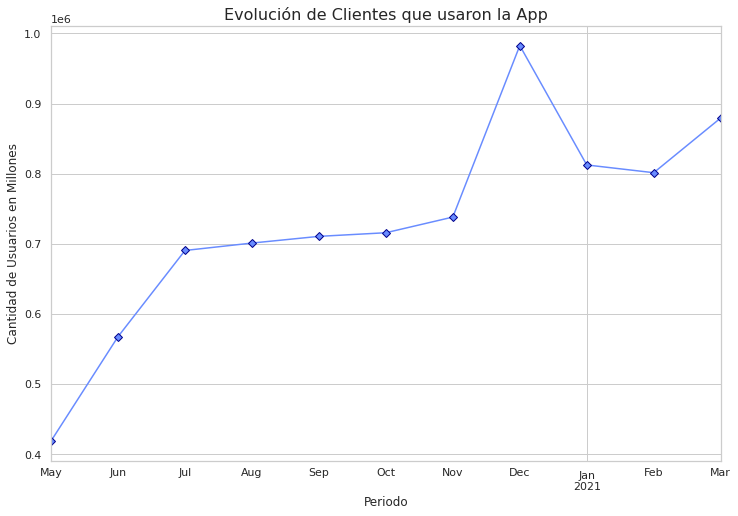

In [16]:
ax = temp.plot(figsize=(12,8), color='#698cff',marker='D', markeredgecolor='darkblue')
ax.set_xlabel("Periodo")
ax.set_ylabel("Cantidad de Usuarios en Millones")
_ = ax.set_title("Evolución de Clientes que usaron la App", fontsize=16)

### Evolución de Clientes Nuevos

In [17]:
temp = df.copy()
temp['periodo_alta'] = pd.to_datetime(df['fecha_alta'], format='%Y/%m').dt.strftime('%Y-%m')

temp = (temp
 .groupby("periodo_alta")
 .account_id
 .agg('count')
)


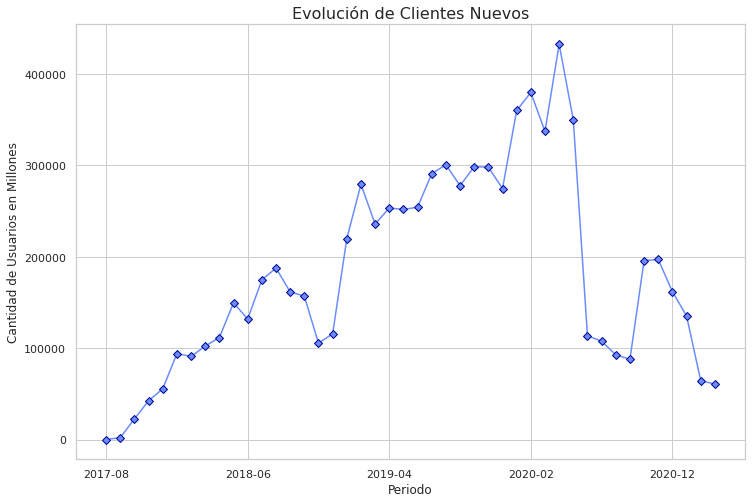

In [49]:
ax = temp.plot(figsize=(12,8), color='#698cff',marker='D', markeredgecolor='darkblue')
ax.set_xlabel("Periodo")
ax.set_ylabel("Cantidad de Usuarios")
_ = ax.set_title("Evolución de Clientes Nuevos", fontsize=16)

## Evolución de Montos Medios Transaccionados

### Cashout

In [18]:
temp = (df
 .groupby("periodo", as_index = False)['vl_compras_aprob',
                        'vl_withdraw_atm_aprob',
                        'vl_investments_deposit_aprob',
                        'vl_telerecargas_carga_aprob',
                        'vl_user_to_user_aprob', 
                        'vl_cash_out_cvu_aprob'
                       ]
 .agg('mean')
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [19]:
temp_pivot = temp.melt(var_name = "cashout",
                     value_name = "Media_usd",
                     id_vars = ["periodo"],
                     value_vars = ['vl_compras_aprob',
                        'vl_withdraw_atm_aprob',
                        'vl_investments_deposit_aprob',
                        'vl_telerecargas_carga_aprob',
                        'vl_user_to_user_aprob', 
                        'vl_cash_out_cvu_aprob']) # out a un cbu o cvu

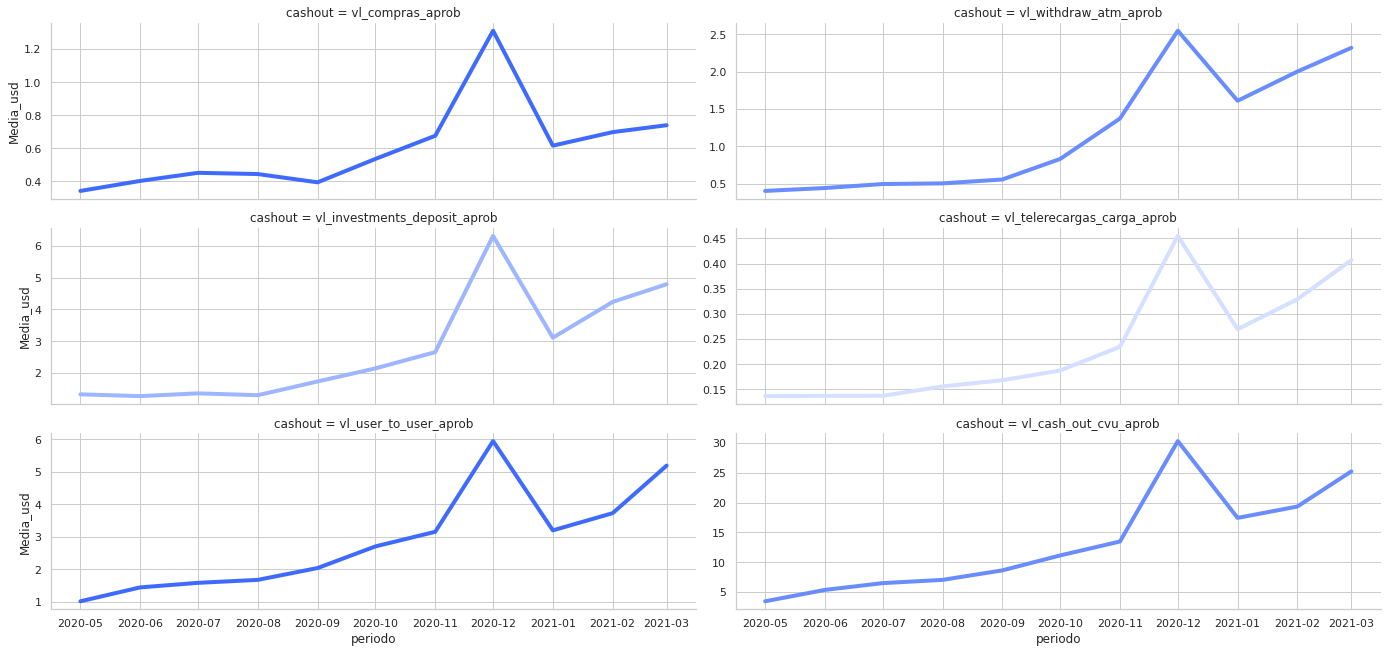

In [20]:
g = sns.relplot(
    data = temp_pivot,
    x="periodo", y="Media_usd", col="cashout", hue="cashout",
    kind="line", palette= ['#3E6BFD','#698cff','#9eb5ff','#d5dfff','#3E6BFD','#698cff'], linewidth=4, zorder=5,
    col_wrap=2, height=3, aspect=3.2, legend=False, facet_kws=dict(sharey=False)
)


### Cashin

In [21]:
temp = (df
 .groupby("periodo", as_index = False)['vl_cashin_efectivo_sum',
                                       'vl_cashin_transferencia_sum']
 .agg('mean')
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


In [22]:
temp_pivot = temp.melt(var_name = "cashin",
                     value_name = "Media_usd",
                     id_vars = ["periodo"],
                     value_vars = ['vl_cashin_efectivo_sum',
                                  'vl_cashin_transferencia_sum'])

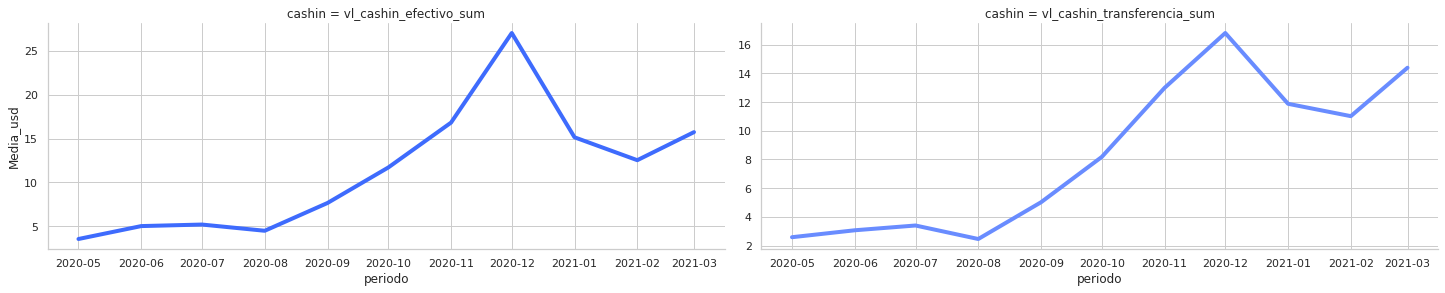

In [24]:
g = sns.relplot(
    data = temp_pivot,
    x="periodo", y="Media_usd", col="cashin", hue="cashin",
    kind="line", palette=['#3E6BFD','#698cff'], linewidth=4, zorder=5,
    col_wrap=2, height=4, aspect=2.5, legend=False, facet_kws=dict(sharey=False)
)

## Evolución de Inicios de Sesión e Incidentes registrados

In [25]:
temp = (df
 .groupby("periodo", as_index = False)['nu_incidente',
                                       'nu_inicio',
                                       'nu_bloqueo']
 .agg('mean')
 .fillna(0)
)

temp_pivot = temp.melt(var_name = "evento",
                       value_name = "cantidad_media",
                       id_vars = ["periodo"],
                       value_vars = ['nu_incidente',
                                     'nu_inicio',
                                    'nu_bloqueo'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


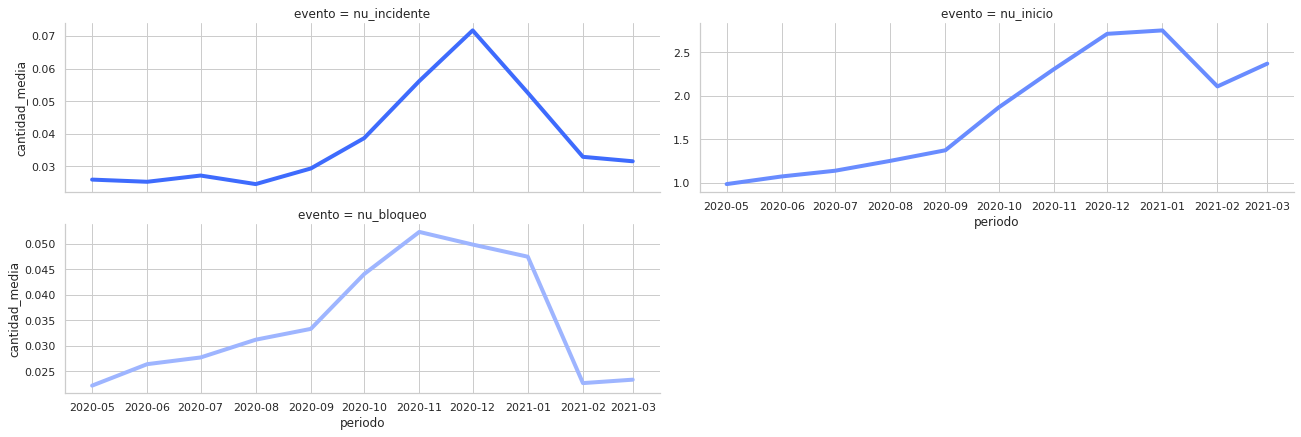

In [26]:
g = sns.relplot(
    data = temp_pivot,
    x="periodo", y="cantidad_media", col="evento", hue="evento",
    kind="line", palette= ['#3E6BFD','#698cff','#9eb5ff'], linewidth=4, zorder=5,
    col_wrap=2, height=3, aspect=3.0, legend=False, facet_kws=dict(sharey=False)
)

## Características Demográficas de los clientes

Antigüedad como cliente

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


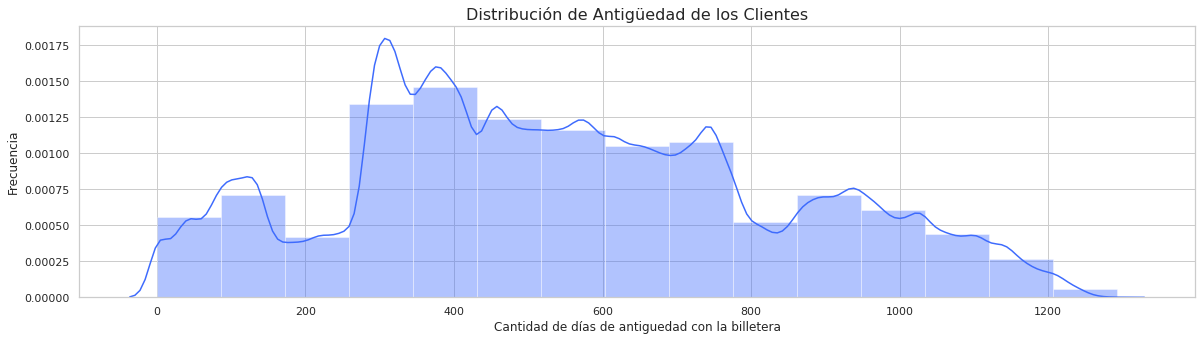

In [30]:
plt.figure(figsize=(20,5))

sns.distplot(df.antiguedad, kde=True, hist=True, bins=15, color='#3E6BFD')
plt.xlabel('Cantidad de días de antiguedad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Antigüedad de los Clientes', fontsize=16)
plt.show()

Edad de los clientes

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


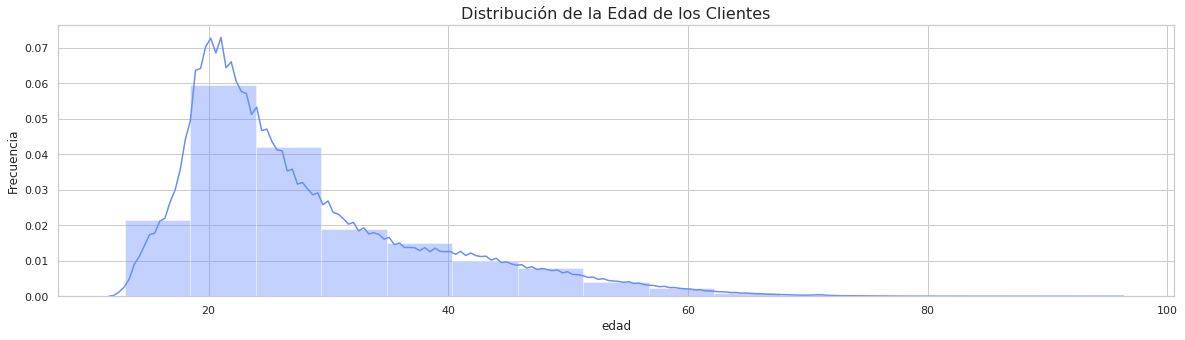

In [28]:
df['fecha_nacimiento'] = pd.to_datetime(df['fecha_nacimiento'], format='%Y/%m/%d')
df['edad']=[math.trunc((datetime.now()-i).days/365)  for i in df['fecha_nacimiento']]
plt.figure(figsize=(20,5))

sns.distplot(df.edad, kde=True, hist=True, bins=15, color='#698cff')
plt.xlabel('edad')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Edad de los Clientes', fontsize=16)

plt.show()

Zonas donde residen los clientes

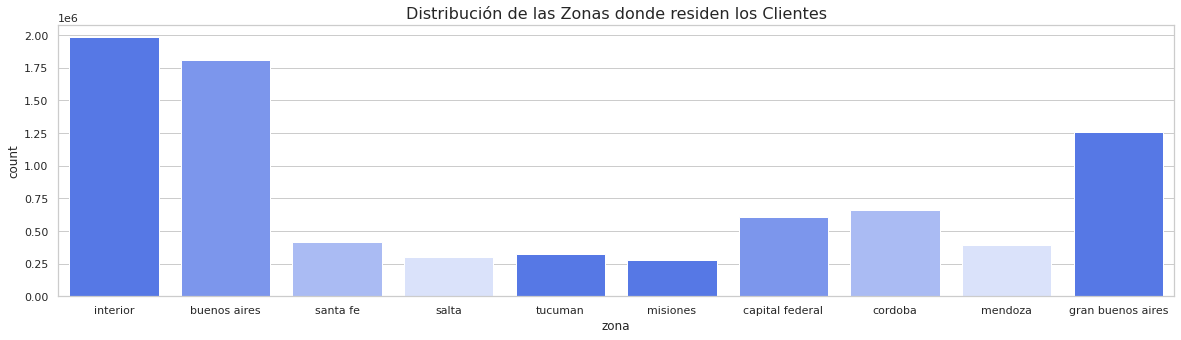

In [31]:
df['zona']=df.provincia.str.lower()
df.loc[-df.provincia.isin(['santa fe','cordoba','buenos aires','capital federal',
                                                            'gran buenos aires','mendoza','tucuman','salta',
                                                           'misiones']),\
                         'zona']='interior'
plt.figure(figsize=(20,5))
sns.countplot(x=df.zona, palette=paleta_uala)
plt.title('Distribución de las Zonas donde residen los Clientes', fontsize=16)

plt.show()

## Empresa Telefónica y Sistema Operativo de los usuarios

Empresa Telefónica

In [32]:
temp = df.copy()

condlist=[
    temp.fl_carrier_claro == 1,
    temp.fl_carrier_movistar == 1,
    temp.fl_carrier_personal == 1,
    temp.fl_carrier_tuenti ==1
    
]

choicelist=['Claro','Movistar','Personal','Tuenti']
temp['cd_empresa_tel']=np.select(condlist,choicelist)
temp['cd_empresa_tel']=(np.where(temp['cd_empresa_tel']=='0','otros',temp['cd_empresa_tel']))

In [33]:
b = temp.groupby(['periodo','cd_empresa_tel']).account_id.count().reset_index(name='cantidad_clientes')
b = b[b.cd_empresa_tel != 'otros']
b['periodo']= b['periodo'].dt.date
b.head(1)

,periodo,cd_empresa_tel,cantidad_clientes
0,2020-05-01,Claro,13314


In [35]:
b_pivot = pd.pivot_table(
    b, 
    values="cantidad_clientes",
    index="periodo",
    columns="cd_empresa_tel", 
    aggfunc='sum'
)
b_pivot.head(1)

cd_empresa_tel,Claro,Movistar,Personal,Tuenti
periodo,,,,
2020-05-01,13314,12660,13237,2488


Text(0, 0.5, 'Cantidad de Clientes')

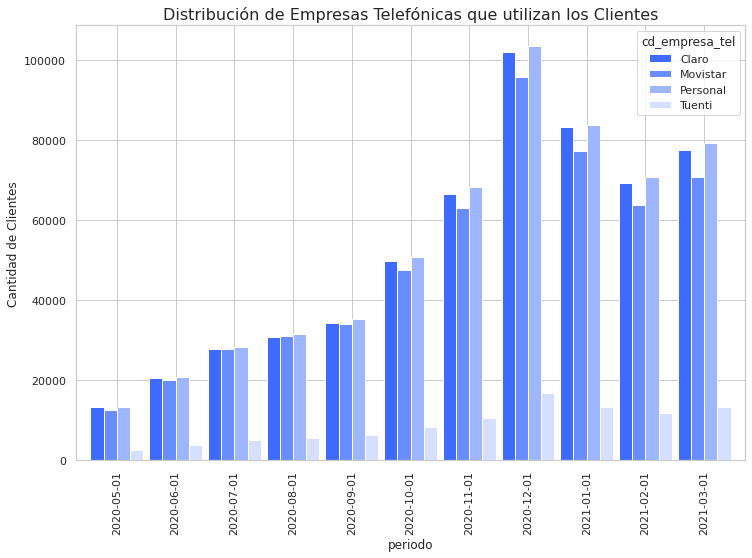

In [36]:
paleta_uala = ['#3E6BFD','#698cff','#9eb5ff','#d5dfff','#3E6BFD']

#import matplotlib.dates as mdates
ax = b_pivot.plot(kind="bar", color= paleta_uala, width=0.9)
fig = ax.get_figure()
fig.set_size_inches(12, 8)

plt.title('Distribución de Empresas Telefónicas que utilizan los Clientes', fontsize=16)
ax.set_xlabel("periodo")
ax.set_ylabel("Cantidad de Clientes")

Sistema Operativo 

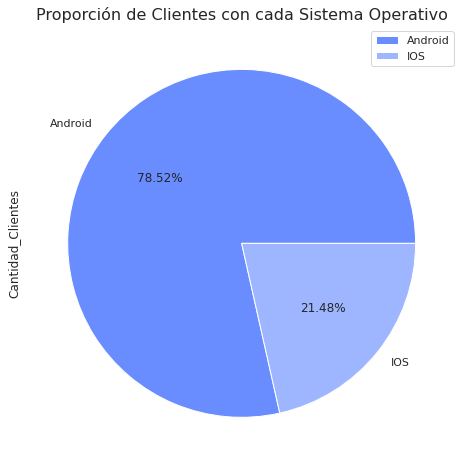

In [37]:
temp["Android_OS"] = np.where(temp.fl_os_android==0,'Android','IOS')
temp_pie = temp.groupby(["Android_OS"])["account_id"].count().reset_index(name="Cantidad_Clientes")

ax = temp_pie.plot.pie(y="Cantidad_Clientes", labels=temp_pie.Android_OS, autopct="%1.2f%%", figsize=(10, 8), colors=['#698cff','#9eb5ff'])
_ = ax.set_title("Proporción de Clientes con cada Sistema Operativo", fontsize=16)

## 1.2 Análisis Multivariado

Matriz de Correlación Total

In [43]:
# Seleccionamos las variables que no queremos tener dentro de la matriz de correlación
a = df.columns.isin(['account_id','year_month','os_name','external_id','periodo','fecha_alta','provincia','sexo','fecha_nacimiento','zona'])
a_comple = df.columns[~a]

# Creamos un df nuevo sin las variables que elegimos
df_ = df.loc[:,a_comple]
df_.head(2)

,cobros,cuotificaciones,inversiones,pago_servicios,prestamos,promociones,recargas,transferencia_c2c,transferencia_cvu,vl_cashin_efectivo_sum,vl_cashin_inversiones_sum,vl_cashin_transferencia_sum,vl_cashin_prestamos_sum,vl_cashin_c2c_sum,vl_cashin_adquirencia_sum,vl_cashin_ajustes_sum,vl_cashin_otros_sum,nu_cashin_efectivo_qty,nu_cashin_inversiones_qty,nu_cashin_transferencia_qty,nu_cashin_prestamos_qty,nu_cashin_c2c_qty,nu_cashin_adquirencia_qty,nu_cashin_ajustes_qty,nu_cashin_otros_qty,nu_tcc_r_aprob,nu_tcc_t_aprob,nu_tcc_z_aprob,vl_tcc_r_aprob,vl_tcc_t_aprob,vl_tcc_z_aprob,nu_mode_digital_qty_0_aprob,nu_mode_digital_qty_1_aprob,nu_automatic_debit_aprob,nu_cash_out_cvu_aprob,nu_consumption_pos_aprob,nu_investments_deposit_aprob,nu_telerecargas_carga_aprob,nu_user_to_user_aprob,nu_withdraw_atm_aprob,vl_automatic_debit_aprob,vl_cash_out_cvu_aprob,vl_consumption_pos_aprob,vl_investments_deposit_aprob,vl_telerecargas_carga_aprob,vl_user_to_user_aprob,vl_withdraw_atm_aprob,nu_compras_otras_categorias_aprob,nu_compras_aprob,nu_entretenimiento_aprob,nu_servicios_débitos_automaticos_aprob,nu_supermercados_alimentos_aprob,nu_transferencias_retiros_aprob,vl_sin_categoria_aprob,vl_compras_aprob,vl_entretenimiento_aprob,vl_servicios_débitos_automaticos_aprob,vl_supermercados_alimentos_aprob,vl_transferencias_retiros_aprob,nu_tcc_r_rech,nu_tcc_t_rech,nu_tcc_z_rech,vl_tcc_r_rech,vl_tcc_t_rech,vl_tcc_z_rech,nu_mode_digital_qty_0_rech,nu_mode_digital_qty_1_rech,nu_automatic_debit_rech,nu_cash_out_cvu_rech,nu_consumption_pos_rech,nu_investments_deposit_rech,nu_telerecargas_carga_rech,nu_user_to_user_rech,nu_withdraw_atm_rech,vl_automatic_debit_rech,vl_cash_out_cvu_rech,vl_consumption_pos_rech,vl_investments_deposit_rech,vl_telerecargas_carga_rech,vl_user_to_user_rech,vl_withdraw_atm_rech,nu_sin_categoria_rech,nu_compras_rech,nu_entretenimiento_rech,nu_servicios_débitos_automaticos_rech,nu_supermercados_alimentos_rech,nu_transferencias_retiros_rech,vl_sin_categoria_rech,vl_compras_rech,vl_entretenimiento_rech,vl_servicios_débitos_automaticos_rech,vl_supermercados_alimentos_rech,vl_transferencias_retiros_rech,fl_os_android,fl_os_ios,nu_bloqueo,nu_incidente,nu_inicio,fl_carrier_claro,fl_carrier_movistar,fl_carrier_personal,fl_carrier_tuenti,antiguedad,edad
0,0,0,0,0,0,0,0,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,28
1,0,0,0,0,0,0,0,8,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,48


In [44]:
# Matriz de correlación (corr en varlores absolutos)
temp = df_.copy()
corr_matrix = temp.corr().abs()

# Seleccionamos triángulo superior
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Vamos a eliminar variables con correlaciones mayores al percentil XXXXX y menores al percentil XXXXXX
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop2 = [column for column in upper.columns if any(upper[column] < 0.005)]

# Eliminamos esas listas
temp.drop(to_drop+to_drop2, axis=1, inplace=True)

temp.shape

(8018021, 13)

In [40]:
# Matríz de Correlación
matriz = temp.corr()
#matriz.style.background_gradient(cmap='coolwarm')

,cobros,cuotificaciones,inversiones,prestamos,promociones,transferencia_c2c,transferencia_cvu,nu_cashin_inversiones_qty,nu_tcc_r_aprob,nu_consumption_pos_aprob,nu_compras_otras_categorias_aprob,nu_incidente,nu_inicio
cobros,1.000000,0.022466,0.047572,0.022941,0.089574,0.045485,0.044420,0.028039,0.013904,0.014150,0.019717,0.031128,0.026560
cuotificaciones,0.022466,1.000000,0.013221,0.029385,0.008980,0.011527,0.010000,0.007659,0.006897,0.012085,0.006433,0.010313,0.009066
inversiones,0.047572,0.013221,1.000000,0.022951,0.053420,0.148038,0.132502,0.330015,0.040906,0.040598,0.106087,0.044557,0.135199
prestamos,0.022941,0.029385,0.022951,1.000000,0.020614,0.012432,0.011303,0.011861,0.006740,0.005270,0.007457,0.020107,0.014396
promociones,0.089574,0.008980,0.053420,0.020614,1.000000,0.049659,0.037611,0.033908,0.025552,0.019568,0.025180,0.066610,0.091924
transferencia_c2c,0.045485,0.011527,0.148038,0.012432,0.049659,1.000000,0.871094,0.103954,0.069065,0.073915,0.510347,0.125159,0.196855
transferencia_cvu,0.044420,0.010000,0.132502,0.011303,0.037611,0.871094,1.000000,0.098753,0.059242,0.053371,0.507845,0.107673,0.163021
nu_cashin_inversiones_qty,0.028039,0.007659,0.330015,0.011861,0.033908,0.103954,0.098753,1.000000,0.199037,0.202746,0.320888,0.141081,0.373914
nu_tcc_r_aprob,0.013904,0.006897,0.040906,0.006740,0.025552,0.069065,0.059242,0.199037,1.000000,0.542407,0.196971,0.130421,0.403821
nu_consumption_pos_aprob,0.014150,0.012085,0.040598,0.005270,0.019568,0.073915,0.053371,0.202746,0.542407,1.000000,0.364330,0.144278,0.397430


Heatmaps

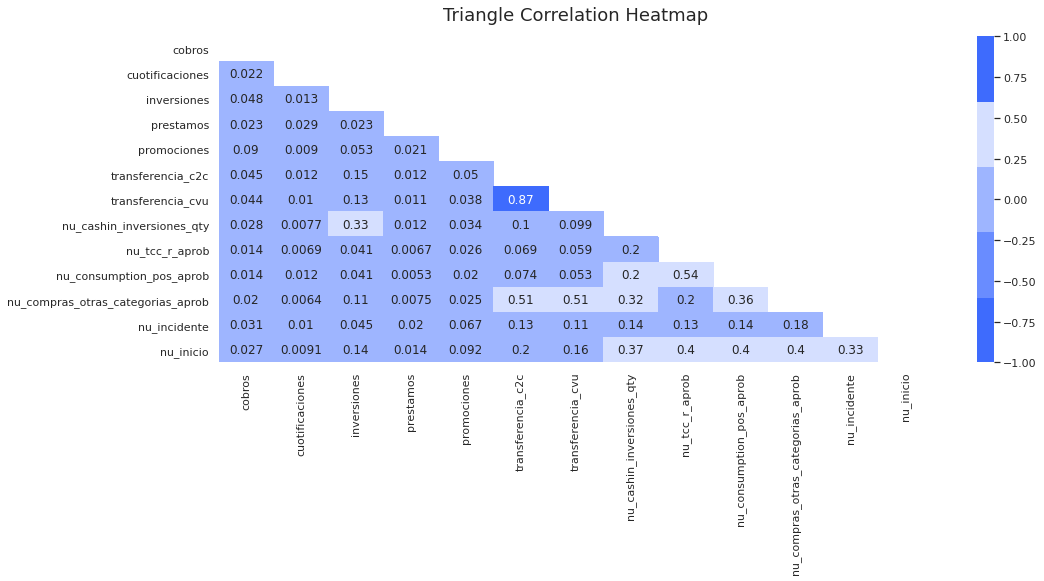

In [41]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(matriz, dtype=np.bool))
heatmap = sns.heatmap(matriz, mask=mask, vmin=-1, vmax=1, annot=True, cmap=paleta_uala)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

* inversiones -> 	transferencia_cvu
* transferencia_c2c -> nu_compras_otras_categorias_aprob	
* nu_cashin_inversiones_qty -> nu_consumption_pos_aprob
* nu_tcc_r_aprob -> nu_incidente
* nu_inicio -> All

## Relaciones Bivariadas

In [42]:
temp.head()

,cobros,cuotificaciones,inversiones,prestamos,promociones,transferencia_c2c,transferencia_cvu,nu_cashin_inversiones_qty,nu_tcc_r_aprob,nu_consumption_pos_aprob,nu_compras_otras_categorias_aprob,nu_incidente,nu_inicio,zona
0,0,0,0,0,0,2,1,0,0,0,0,0,0,interior
1,0,0,0,0,0,8,4,0,0,0,0,0,0,buenos aires
2,0,0,6,0,0,1,0,0,0,0,0,0,0,buenos aires
3,0,0,48,0,2,17,7,0,0,0,0,0,0,interior
4,0,0,0,0,0,6,3,0,0,0,0,0,0,santa fe


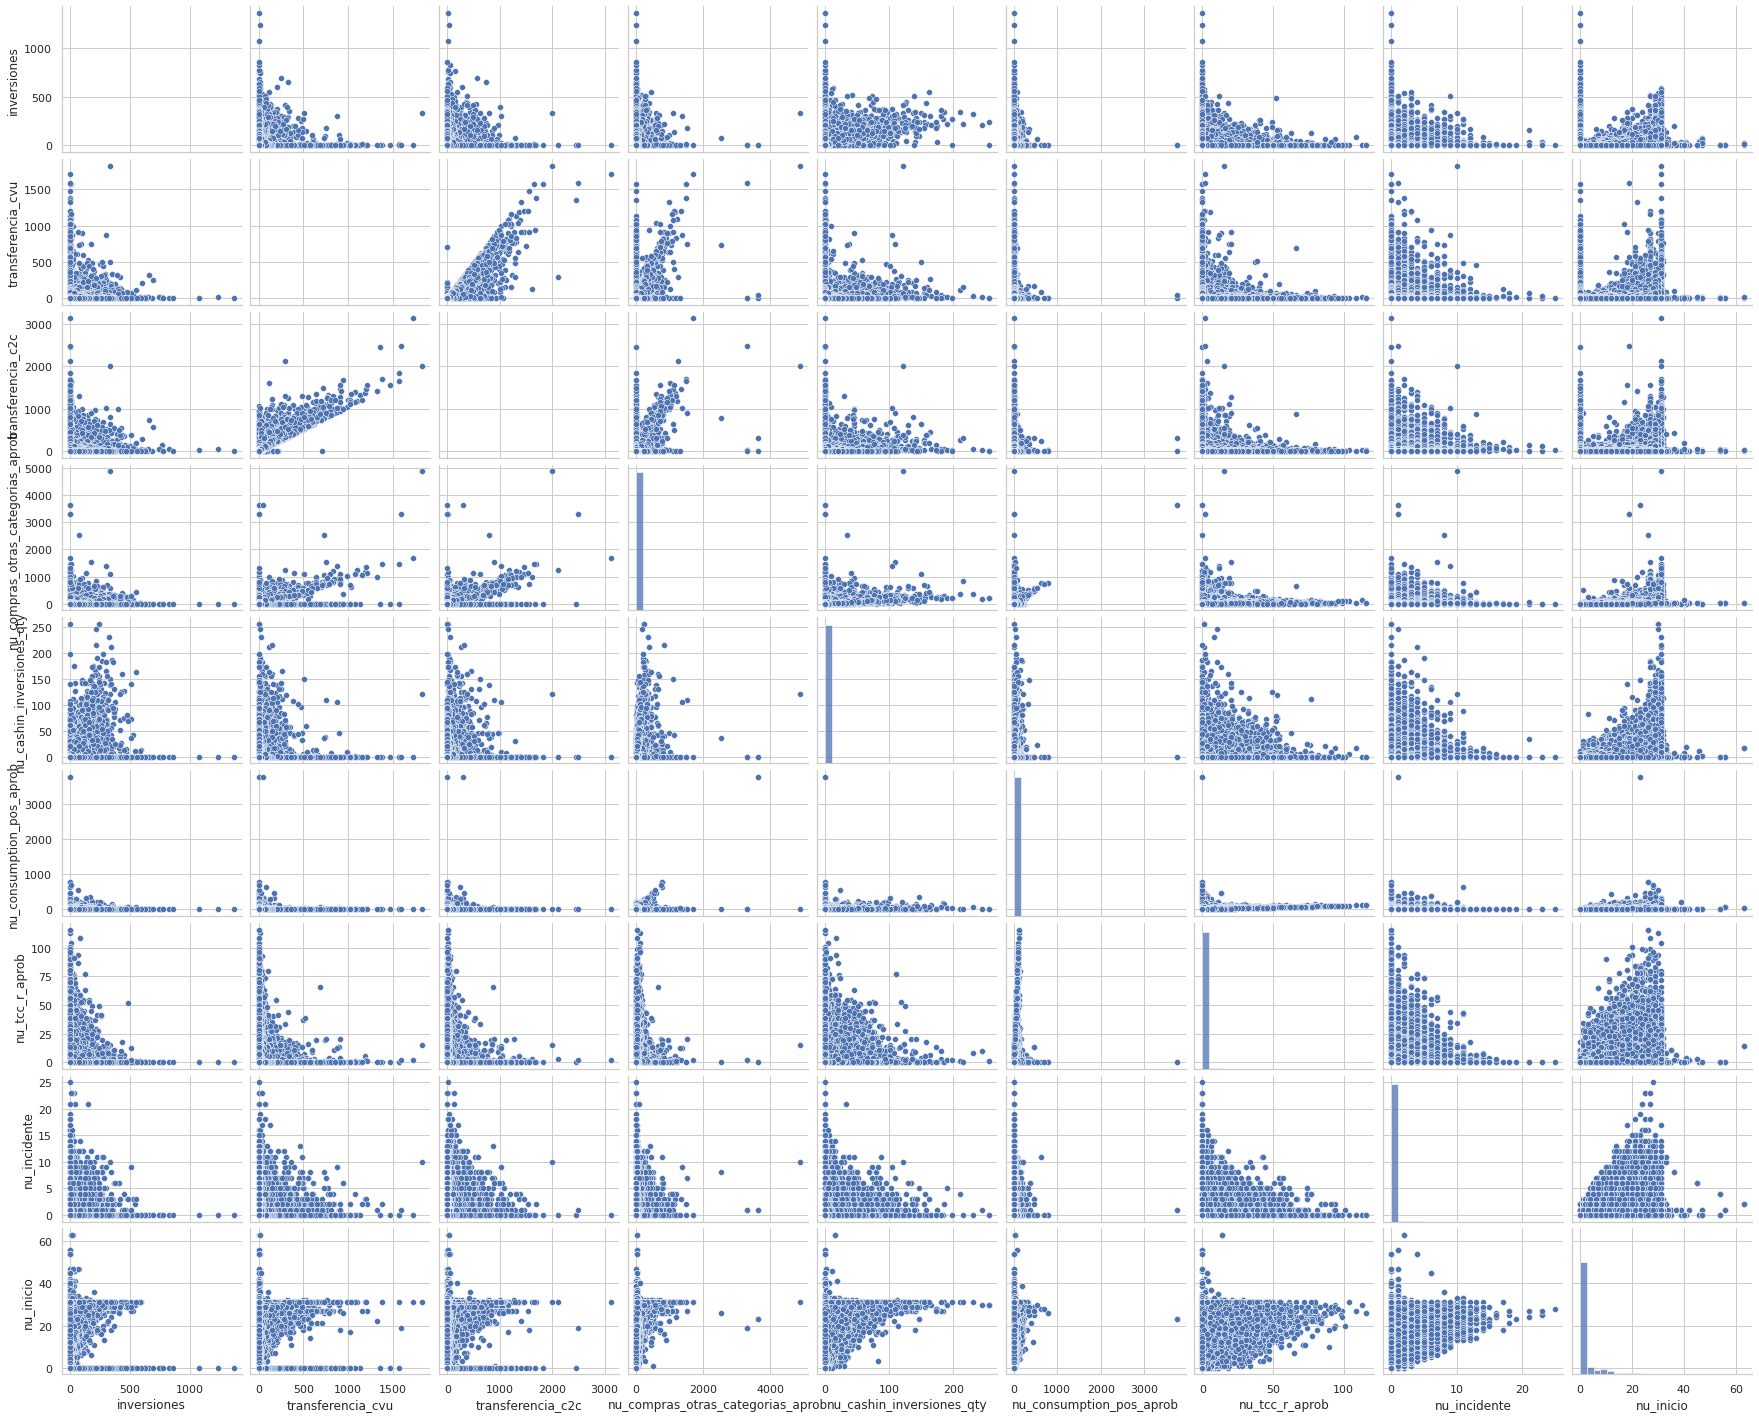

In [67]:
#plt.figure(figsize=(16,12))
g=sns.pairplot(
    temp,
    x_vars=["inversiones", "transferencia_cvu", "transferencia_c2c", "nu_compras_otras_categorias_aprob", 
"nu_cashin_inversiones_qty", "nu_consumption_pos_aprob", "nu_tcc_r_aprob", "nu_incidente", "nu_inicio"],
    y_vars=["inversiones", "transferencia_cvu", "transferencia_c2c", "nu_compras_otras_categorias_aprob", 
"nu_cashin_inversiones_qty", "nu_consumption_pos_aprob", "nu_tcc_r_aprob", "nu_incidente", "nu_inicio"], 
    #height = 6,
    #aspect=0.5
)
g.fig.set_figheight(20)
g.fig.set_figwidth(25)
plt.show()

* trnasferecnia_cvu con nu_compras_otras_categ
* nu_inicio con cahin_inv
* nu_inicio con tcc_r_aprob
* 

## Tests de hipotesis

In [100]:
scipy.stats.pearsonr(df["nu_inicio"].values,
                     df["nu_compras_otras_categorias_aprob"].values)

(0.40240898225447025, 0.0)

In [99]:
scipy.stats.pearsonr(df["nu_inicio"].values,
                     df["nu_tcc_r_aprob"].values)

(0.4038207004427308, 0.0)

In [98]:
scipy.stats.pearsonr(df["transferencia_cvu"].values,
                     df["transferencia_c2c"].values)

(0.8710935897451622, 0.0)

In [ ]:
pg.ttest(list(df["transferencia_cvu"].values),
         list(df["transferencia_c2c"].values))

## Rain plot

In [ ]:
df['zona2'] = np.where(df.zona.isin(['buenos aires','capital federal','gran buenos aires']),"Buenos Aires","Otros")

<AxesSubplot:xlabel='zona', ylabel='nu_compras_otras_categorias_aprob'>

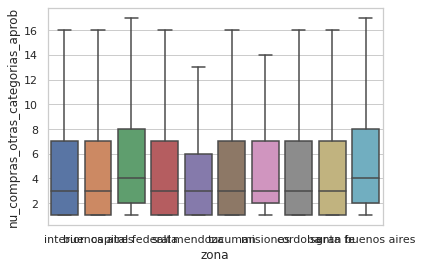

In [130]:
sns.boxplot(x="zona",
            y="nu_compras_otras_categorias_aprob",
            data=df[df.nu_compras_otras_categorias_aprob > 0],
           showfliers=False)

In [124]:
df['vl_consumption_pos_aprob'].describe()

count    8.018021e+06
mean     3.462886e+00
std      3.634524e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.695467e+04
Name: vl_consumption_pos_aprob, dtype: float64

# Apriori

In [150]:
# Creamos un df nuevo sin las variables que elegimos
df_.drop('edad',axis=1, inplace=True)
df_.head(2)

MemoryError: Unable to allocate 2.63 GiB for an array with shape (44, 8018021) and data type float64

In [151]:
data_pivot = pd.melt(df_, 
                     id_vars='account_id', 
                     var_name='producto', 
                     value_name='value')

MemoryError: Unable to allocate 2.63 GiB for an array with shape (44, 8018021) and data type float64

In [ ]:
data_pivot = data_pivot[data_pivot.value > 0]

In [ ]:
data_pivot.head()

In [ ]:
data_matriz = (data_pivot
               .groupby(['account_id', 'producto'])['value']
               .sum().unstack().reset_index().fillna(0)
               .set_index('account_id'))

data_matriz.head()

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

data_matriz = data_matriz.applymap(encode_units)

In [ ]:
data_matriz_test = data_matriz[['cobros',
 'cuotificaciones',
 'inversiones',
 'pago_servicios',
 'prestamos',
 'promociones',
 'recargas',
 'transferencia_c2c',
 'transferencia_cvu',
 'nu_cashin_efectivo_qty',
 'nu_cashin_inversiones_qty',
 'nu_cashin_transferencia_qty',
 'nu_cashin_prestamos_qty',
 'nu_cashin_c2c_qty',
 'nu_cashin_adquirencia_qty',
 'nu_cashin_ajustes_qty',
 'nu_cashin_otros_qty',
 'nu_tcc_r_aprob',
 'nu_tcc_t_aprob',
 'nu_tcc_z_aprob',
 'nu_mode_digital_qty_0_aprob',
 'nu_mode_digital_qty_1_aprob',
 'nu_automatic_debit_aprob',
 'nu_cash_out_cvu_aprob',
 'nu_consumption_pos_aprob',
 'nu_investments_deposit_aprob',
 'nu_telerecargas_carga_aprob',
 'nu_user_to_user_aprob',
 'nu_withdraw_atm_aprob',
 'nu_sin_categoria_aprob',
 'nu_compras_aprob',
 'nu_entretenimiento_aprob',
 'nu_servicios_débitos_automaticos_aprob',
 'nu_supermercados_alimentos_aprob',
 'nu_transferencias_retiros_aprob',
 'nu_tcc_r_rech',
 'nu_tcc_t_rech',
 'nu_tcc_z_rech',
 'nu_mode_digital_qty_0_rech',
 'nu_mode_digital_qty_1_rech',
 'nu_automatic_debit_rech',
 'nu_cash_out_cvu_rech',
 'nu_consumption_pos_rech',
 'nu_investments_deposit_rech',
 'nu_telerecargas_carga_rech',
 'nu_user_to_user_rech',
 'nu_withdraw_atm_rech',
 'nu_sin_categoria_rech',
 'nu_compras_rech',
 'nu_entretenimiento_rech',
 'nu_servicios_débitos_automaticos_rech',
 'nu_supermercados_alimentos_rech',
 'nu_transferencias_retiros_rech',
 'fl_os_android',
 'fl_os_ios',
 'nu_bloqueo',
 'nu_incidente',
 'nu_inicio',
 'fl_carrier_claro',
 'fl_carrier_movistar',
 'fl_carrier_personal',
 'fl_carrier_tuenti']]

In [ ]:
nu_compras_aprob
nu_withdraw_atm_aprob
nu_investments_deposit_aprob
nu_telerecargas_carga_aprob
nu_user_to_user_aprob
nu_cash_out_cvu_aprob

In [ ]:
data_matriz.head()

In [ ]:
itemsets = apriori(data_matriz, min_support=0.1, use_colnames=True)

In [ ]:
rules = association_rules(itemsets, metric="lift", min_threshold=1)

In [ ]:
rules